In [17]:
import numpy as np
import pandas as pd
import re

In [18]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
# pd.set_option('display.max_colwidth',None)

In [19]:
df = pd.read_csv('gurgoan_properties_cleaned_v1.csv')

In [20]:
df.head(1)
# focus is on -? areaWithtype, additionalRoom, agePossession, furnishDetails, features

,society,price,sector,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_type
0,ambience creacions,6.0,sector 22,20533.0,29221.0,Carpet area: 3000 (278.71 sq.m.),4,5,3+,"pooja room,servant room",10.0,South-East,0 to 1 Year Old,"['Moulsari Avenue', 'Ambience Mall', 'Old Delhi Gurgaon Road', 'Gurgaon - Delhi Expy', 'Rotary Public School', 'The NorthCap University', 'Manipal Hospital, Palam Vihar', 'Indira Gandhi International Airport', 'Gurgaon Railway Station', 'Candor Techspace', 'Hyatt Place Gurgaon Udyog Vihar', 'Fun N Food WaterPark', 'Hamoni Golf Camp', 'Tau DeviLal Sports Complex']","['4 Wardrobe', '6 Fan', '1 Exhaust Fan', '4 Geyser', '1 Washing Machine', '6 Light', '1 Chimney', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']",NaN


## 1. areaWithType

- Super Builtup Area - Total Area + additional common area
- Built up area - carpet area + thickness of walls + balcony area
- Carpet area - building area (rooms, kitchen)

In [21]:
df[['area','areaWithType']].sample(5)

,area,areaWithType
857,23234.0,Super Built up area 3090(287.07 sq.m.)
1700,543.0,Super Built up area 575(53.42 sq.m.)Carpet area: 570.17 sq.ft. (52.97 sq.m.)
3490,13219.0,Super Built up area 2450(227.61 sq.m.)Built Up area: 2400 sq.ft. (222.97 sq.m.)Carpet area: 2300 sq.ft. (213.68 sq.m.)
2868,14754.0,Super Built up area 1844(171.31 sq.m.)
473,16431.0,Carpet area: 2300 (213.68 sq.m.)


In [22]:
# This function extract the Super Built up area
def get_super_built_up_area(text):
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None


In [23]:
# This function extracts the built up area or carpet area
def get_area(text, area_type):
    match = re.search(area_type + r'\s*:\s(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [24]:
# This function checks if the area is provided in sq.m. and converts it t sqft if needed
def convert_to_sqft(text, area_value):
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639 #conversion factor from sq.m. to sqft
    return area_value

In [25]:
# Extract super built up area and convert to sqft if needed
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)
df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built up area and convert to sqft if needed
df['built_up_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Built Up area'))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)


In [26]:
df[['price', 'property_type', 'area', 'areaWithType','super_built_up_area', 'built_up_area', 'carpet_area']].sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
692,1.00,NaN,14092.0,Super Built up area 1550(144 sq.m.)Carpet area: 1200 sq.ft. (111.48 sq.m.),1550.0,NaN,1200.0
1724,0.03,NaN,500.0,Super Built up area 583(54.16 sq.m.),583.0,NaN,NaN
1423,0.96,house,960.0,Plot area 945(87.79 sq.m.),NaN,NaN,NaN
416,0.09,NaN,1283.0,Super Built up area 1283(119.19 sq.m.),1283.0,NaN,NaN
463,0.09,NaN,974.0,Carpet area: 1050 (97.55 sq.m.),NaN,NaN,1050.0


In [27]:
df.duplicated().sum()

123

In [28]:
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area']).isnull())][['price','property_type', 'area', 'areaWithType','super_built_up_area','built_up_area','carpet_area']].shape

(534, 7)

In [29]:
df.head()

,society,price,sector,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_type,super_built_up_area,built_up_area,carpet_area
0,ambience creacions,6.00,sector 22,20533.0,29221.0,Carpet area: 3000 (278.71 sq.m.),4,5,3+,"pooja room,servant room",10.0,South-East,0 to 1 Year Old,"['Moulsari Avenue', 'Ambience Mall', 'Old Delhi Gurgaon Road', 'Gurgaon - Delhi Expy', 'Rotary Public School', 'The NorthCap University', 'Manipal Hospital, Palam Vihar', 'Indira Gandhi International Airport', 'Gurgaon Railway Station', 'Candor Techspace', 'Hyatt Place Gurgaon Udyog Vihar', 'Fun N Food WaterPark', 'Hamoni Golf Camp', 'Tau DeviLal Sports Complex']","['4 Wardrobe', '6 Fan', '1 Exhaust Fan', '4 Geyser', '1 Washing Machine', '6 Light', '1 Chimney', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']",NaN,NaN,NaN,3000.0
1,m3m woodshire,1.00,sector 107,7496.0,13340.0,Super Built up area 1534(142.51 sq.m.)Carpet area: 1056 sq.ft. (98.11 sq.m.),2,2,3,study room,0.0,North-East,1 to 5 Year Old,"['Signum 107', 'Nora Solomon Medicenter', 'Indira Gandhi International Airport', 'The Shikshiyan School', 'Najafgarh Jheel Bird Sanctuary', 'Skylark Cricket Academy']","['5 Fan', '1 Geyser', '5 Light', '4 AC', '1 Modular Kitchen', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Park', 'Natural Light']",NaN,1534.0,NaN,1056.0
2,satya the legend,9.25,sector 57,16577.0,5580.0,Plot area 642(536.79 sq.m.)Built Up area: 630 sq.yards (526.76 sq.m.)Carpet area: 620 sq.yards (518.4 sq.m.),5,5,3+,"study room,servant room,pooja room,store room",4.0,North-East,1 to 5 Year Old,"['HDFC Bank ATM', 'ICICI Bank ATM', 'YES Bank ATM', 'Axis Bank ATM', 'Indusind bank ATM', 'CK Birla Hospital', 'Suryadeep Hospital', 'Park Hospital', 'W Pratiksha Hospital', 'Cloudnine Hospital', 'Garari', 'Dreamz Cafe', 'Culinary Blend', 'Delectable Cafe', 'Dana Choga']","['1 Water Purifier', '9 Fan', '1 Exhaust Fan', '6 Geyser', '44 Light', '7 AC', '1 Modular Kitchen', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Fitness Centre / GYM', 'Club house / Community Center']",house,NaN,630.0,620.0
3,vatika gurgaon,0.07,sector 83,6265.0,1117.0,Super Built up area 1245(115.66 sq.m.)Built Up area: 850 sq.ft. (78.97 sq.m.)Carpet area: 790 sq.ft. (73.39 sq.m.),2,2,2,"pooja room,study room",3.0,South-East,1 to 5 Year Old,"['Huda Metro Station (Gurugram)', 'Sapphire 83 Mall', 'Vatika Sector Road', 'Gurgaon - Delhi Expy', 'Dwarka Expy', 'Euro International School, Sec 84', 'DPG Degree College', 'Aarvy Healthcare Super Speciality', 'Indira Gandhi Intl Airport', 'Garhi Harsaru Junction']","['5 Fan', '1 Exhaust Fan', '3 Geyser', '5 Light', '1 Modular Kitchen', '1 Chimney', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Wa

In [30]:
df[df['areaWithType'].str.contains('Plot')][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].head(5)


,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2,9.25,house,5580.0,Plot area 642(536.79 sq.m.)Built Up area: 630 sq.yards (526.76 sq.m.)Carpet area: 620 sq.yards (518.4 sq.m.),NaN,630.0,620.0
7,0.75,house,1095.0,Plot area 1095(101.73 sq.m.),NaN,NaN,NaN
18,4.49,house,1836.0,Plot area 204(170.57 sq.m.),NaN,NaN,NaN
23,9.50,house,4050.0,Plot area 502(419.74 sq.m.)Built Up area: 500 sq.yards (418.06 sq.m.)Carpet area: 450 sq.yards (376.26 sq.m.),NaN,500.0,450.0
28,23.00,house,9000.0,Plot area 1000(836.13 sq.m.),NaN,NaN,NaN


In [31]:
df.isnull().sum()

society                   1
price                    18
sector                    0
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
property_type          2943
super_built_up_area    1888
built_up_area          2616
carpet_area            1859
dtype: int64

In [32]:
all_nan_df = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]

In [33]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
7,0.75,house,1095.0,Plot area 1095(101.73 sq.m.),NaN,NaN,NaN
18,4.49,house,1836.0,Plot area 204(170.57 sq.m.),NaN,NaN,NaN
28,23.00,house,9000.0,Plot area 1000(836.13 sq.m.),NaN,NaN,NaN
35,7.00,house,3240.0,Plot area 360(301.01 sq.m.),NaN,NaN,NaN
36,5.00,house,215517.0,Plot area 2(1011.71 sq.m.),NaN,NaN,NaN


In [34]:
all_nan_index = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].index

In [35]:
# Function to extract plot area from 'areaWithType' column
def extract_plot_area(area_with_type):
    match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
    return float(match.group(1)) if match else None

In [36]:
all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

# Update the original dataframe
# gurgaon_properties.update(filtered_rows)

In [38]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
7,0.75,house,1095.0,Plot area 1095(101.73 sq.m.),NaN,1095.0,NaN
18,4.49,house,1836.0,Plot area 204(170.57 sq.m.),NaN,204.0,NaN
28,23.00,house,9000.0,Plot area 1000(836.13 sq.m.),NaN,1000.0,NaN
35,7.00,house,3240.0,Plot area 360(301.01 sq.m.),NaN,360.0,NaN
36,5.00,house,215517.0,Plot area 2(1011.71 sq.m.),NaN,2.0,NaN


In [39]:
def convert_scale(row):
    if np.isnan(row['area'] or np.isnan(row['built_up_area'])):
        return row['built_up_area']
    else:
        if round(row['area']/row['built_up_area']) == 9.0:
            return row['built_up_area'] * 9
        elif round(row['area']/row['built_up_area']) == 11.0:
            return row['built_up_area'] * 10.7
        else:
            return row['built_up_area']

In [40]:
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale, axis=1)

In [42]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
7,0.75,house,1095.0,Plot area 1095(101.73 sq.m.),NaN,1095.0,NaN
18,4.49,house,1836.0,Plot area 204(170.57 sq.m.),NaN,1836.0,NaN
28,23.00,house,9000.0,Plot area 1000(836.13 sq.m.),NaN,9000.0,NaN
35,7.00,house,3240.0,Plot area 360(301.01 sq.m.),NaN,3240.0,NaN
36,5.00,house,215517.0,Plot area 2(1011.71 sq.m.),NaN,2.0,NaN


In [43]:
# Update the original dataframe
df.update(all_nan_df)

In [44]:
df.isnull().sum()

society                   1
price                    18
sector                    0
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
property_type          2943
super_built_up_area    1888
built_up_area          2070
carpet_area            1859
dtype: int64

In [45]:
df.head()

,society,price,sector,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_type,super_built_up_area,built_up_area,carpet_area
0,ambience creacions,6.00,sector 22,20533.0,29221.0,Carpet area: 3000 (278.71 sq.m.),4,5,3+,"pooja room,servant room",10.0,South-East,0 to 1 Year Old,"['Moulsari Avenue', 'Ambience Mall', 'Old Delhi Gurgaon Road', 'Gurgaon - Delhi Expy', 'Rotary Public School', 'The NorthCap University', 'Manipal Hospital, Palam Vihar', 'Indira Gandhi International Airport', 'Gurgaon Railway Station', 'Candor Techspace', 'Hyatt Place Gurgaon Udyog Vihar', 'Fun N Food WaterPark', 'Hamoni Golf Camp', 'Tau DeviLal Sports Complex']","['4 Wardrobe', '6 Fan', '1 Exhaust Fan', '4 Geyser', '1 Washing Machine', '6 Light', '1 Chimney', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']",NaN,NaN,NaN,3000.0
1,m3m woodshire,1.00,sector 107,7496.0,13340.0,Super Built up area 1534(142.51 sq.m.)Carpet area: 1056 sq.ft. (98.11 sq.m.),2,2,3,study room,0.0,North-East,1 to 5 Year Old,"['Signum 107', 'Nora Solomon Medicenter', 'Indira Gandhi International Airport', 'The Shikshiyan School', 'Najafgarh Jheel Bird Sanctuary', 'Skylark Cricket Academy']","['5 Fan', '1 Geyser', '5 Light', '4 AC', '1 Modular Kitchen', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Park', 'Natural Light']",NaN,1534.0,NaN,1056.0
2,satya the legend,9.25,sector 57,16577.0,5580.0,Plot area 642(536.79 sq.m.)Built Up area: 630 sq.yards (526.76 sq.m.)Carpet area: 620 sq.yards (518.4 sq.m.),5,5,3+,"study room,servant room,pooja room,store room",4.0,North-East,1 to 5 Year Old,"['HDFC Bank ATM', 'ICICI Bank ATM', 'YES Bank ATM', 'Axis Bank ATM', 'Indusind bank ATM', 'CK Birla Hospital', 'Suryadeep Hospital', 'Park Hospital', 'W Pratiksha Hospital', 'Cloudnine Hospital', 'Garari', 'Dreamz Cafe', 'Culinary Blend', 'Delectable Cafe', 'Dana Choga']","['1 Water Purifier', '9 Fan', '1 Exhaust Fan', '6 Geyser', '44 Light', '7 AC', '1 Modular Kitchen', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Fitness Centre / GYM', 'Club house / Community Center']",house,NaN,630.0,620.0
3,vatika gurgaon,0.07,sector 83,6265.0,1117.0,Super Built up area 1245(115.66 sq.m.)Built Up area: 850 sq.ft. (78.97 sq.m.)Carpet area: 790 sq.ft. (73.39 sq.m.),2,2,2,"pooja room,study room",3.0,South-East,1 to 5 Year Old,"['Huda Metro Station (Gurugram)', 'Sapphire 83 Mall', 'Vatika Sector Road', 'Gurgaon - Delhi Expy', 'Dwarka Expy', 'Euro International School, Sec 84', 'DPG Degree College', 'Aarvy Healthcare Super Speciality', 'Indira Gandhi Intl Airport', 'Garhi Harsaru Junction']","['5 Fan', '1 Exhaust Fan', '3 Geyser', '5 Light', '1 Modular Kitchen', '1 Chimney', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Wa

## 2. Additional Room

In [46]:
df['additionalRoom'].value_counts()

additionalRoom
not available                                    1587
servant room                                      705
study room                                        250
others                                            225
pooja room                                        165
study room,servant room                            99
store room                                         99
pooja room,servant room                            82
pooja room,study room,servant room,store room      72
servant room,others                                60
pooja room,study room,servant room                 55
pooja room,study room,servant room,others          54
servant room,pooja room                            38
servant room,store room                            33
study room,others                                  29
pooja room,study room                              22
pooja room,others                                  17
pooja room,store room                              15
servant room,

In [50]:
# additional room
# List of new columns to be created
new_cols = ['study room', 'servant room','store room','pooja room','others']

# populate the new columns based on the 'additionalRoom' column
for col in new_cols:
    df[col] = df['additionalRoom'].str.contains(col).astype(int)

In [51]:
df.sample(5)[['additionalRoom','study room', 'servant room','store room','pooja room','others']]

,additionalRoom,study room,servant room,store room,pooja room,others
254,"pooja room,study room,servant room,store room",1,1,1,1,0
701,not available,0,0,0,0,0
827,not available,0,0,0,0,0
105,servant room,0,1,0,0,0
371,"pooja room,servant room",0,1,0,1,0


In [52]:
df.head()

,society,price,sector,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_type,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,ambience creacions,6.00,sector 22,20533.0,29221.0,Carpet area: 3000 (278.71 sq.m.),4,5,3+,"pooja room,servant room",10.0,South-East,0 to 1 Year Old,"['Moulsari Avenue', 'Ambience Mall', 'Old Delhi Gurgaon Road', 'Gurgaon - Delhi Expy', 'Rotary Public School', 'The NorthCap University', 'Manipal Hospital, Palam Vihar', 'Indira Gandhi International Airport', 'Gurgaon Railway Station', 'Candor Techspace', 'Hyatt Place Gurgaon Udyog Vihar', 'Fun N Food WaterPark', 'Hamoni Golf Camp', 'Tau DeviLal Sports Complex']","['4 Wardrobe', '6 Fan', '1 Exhaust Fan', '4 Geyser', '1 Washing Machine', '6 Light', '1 Chimney', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']",NaN,NaN,NaN,3000.0,0,1,0,1,0
1,m3m woodshire,1.00,sector 107,7496.0,13340.0,Super Built up area 1534(142.51 sq.m.)Carpet area: 1056 sq.ft. (98.11 sq.m.),2,2,3,study room,0.0,North-East,1 to 5 Year Old,"['Signum 107', 'Nora Solomon Medicenter', 'Indira Gandhi International Airport', 'The Shikshiyan School', 'Najafgarh Jheel Bird Sanctuary', 'Skylark Cricket Academy']","['5 Fan', '1 Geyser', '5 Light', '4 AC', '1 Modular Kitchen', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Park', 'Natural Light']",NaN,1534.0,NaN,1056.0,1,0,0,0,0
2,satya the legend,9.25,sector 57,16577.0,5580.0,Plot area 642(536.79 sq.m.)Built Up area: 630 sq.yards (526.76 sq.m.)Carpet area: 620 sq.yards (518.4 sq.m.),5,5,3+,"study room,servant room,pooja room,store room",4.0,North-East,1 to 5 Year Old,"['HDFC Bank ATM', 'ICICI Bank ATM', 'YES Bank ATM', 'Axis Bank ATM', 'Indusind bank ATM', 'CK Birla Hospital', 'Suryadeep Hospital', 'Park Hospital', 'W Pratiksha Hospital', 'Cloudnine Hospital', 'Garari', 'Dreamz Cafe', 'Culinary Blend', 'Delectable Cafe', 'Dana Choga']","['1 Water Purifier', '9 Fan', '1 Exhaust Fan', '6 Geyser', '44 Light', '7 AC', '1 Modular Kitchen', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Fitness Centre / GYM', 'Club house / Community Center']",house,NaN,630.0,620.0,1,1,1,1,0
3,vatika gurgaon,0.07,sector 83,6265.0,1117.0,Super Built up area 1245(115.66 sq.m.)Built Up area: 850 sq.ft. (78.97 sq.m.)Carpet area: 790 sq.ft. (73.39 sq.m.),2,2,2,"pooja room,study room",3.0,South-East,1 to 5 Year Old,"['Huda Metro Station (Gurugram)', 'Sapphire 83 Mall', 'Vatika Sector Road', 'Gurgaon - Delhi Expy', 'Dwarka Expy', 'Euro International School, Sec 84', 'DPG Degree College', 'Aarvy Healthcare Super Speciality', 'Indira Gandhi Intl Airport', 'Garhi Harsaru Junction']","['5 Fan', '1 Exhaust Fan', '3 Geyser', '5 Light', '1 Modular Kitchen', '1 Chimney', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No F

## 3.agePossession

In [53]:
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1676
5 to 10 Year Old       575
0 to 1 Year Old        530
undefined              332
10+ Year Old           310
Under Construction      90
Within 6 months         70
Within 3 months         26
Dec 2023                22
By 2023                 19
By 2024                 17
Dec 2024                16
Mar 2024                14
Jan 2024                 8
Oct 2024                 8
Jun 2024                 7
Aug 2023                 7
Dec 2025                 7
Nov 2023                 5
Jul 2024                 4
By 2025                  4
Aug 2024                 4
Sep 2023                 4
Oct 2023                 4
May 2024                 3
Nov 2024                 3
Feb 2024                 3
Jan 2025                 3
By 2027                  2
Jan 2026                 2
Dec 2026                 2
Oct 2025                 2
Mar 2025                 2
Sep 2025                 2
Apr 2026                 2
Jul 2027                 2
Aug 2025      

In [54]:
def categorize_age_possession(value):
    if pd.isna(value):
        return 'Undefined'
    
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately Old"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        # For entries like 'May 2024'
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"
    

In [55]:
df['agePossession'] = df['agePossession'].apply(categorize_age_possession)

In [56]:
df['agePossession'].value_counts()

agePossession
Relatively New        1676
New Property           626
Moderately Old         575
Undefined              333
Old Property           310
Under Construction     283
Name: count, dtype: int64

In [57]:
df.head()

,society,price,sector,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_type,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,ambience creacions,6.00,sector 22,20533.0,29221.0,Carpet area: 3000 (278.71 sq.m.),4,5,3+,"pooja room,servant room",10.0,South-East,New Property,"['Moulsari Avenue', 'Ambience Mall', 'Old Delhi Gurgaon Road', 'Gurgaon - Delhi Expy', 'Rotary Public School', 'The NorthCap University', 'Manipal Hospital, Palam Vihar', 'Indira Gandhi International Airport', 'Gurgaon Railway Station', 'Candor Techspace', 'Hyatt Place Gurgaon Udyog Vihar', 'Fun N Food WaterPark', 'Hamoni Golf Camp', 'Tau DeviLal Sports Complex']","['4 Wardrobe', '6 Fan', '1 Exhaust Fan', '4 Geyser', '1 Washing Machine', '6 Light', '1 Chimney', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']",NaN,NaN,NaN,3000.0,0,1,0,1,0
1,m3m woodshire,1.00,sector 107,7496.0,13340.0,Super Built up area 1534(142.51 sq.m.)Carpet area: 1056 sq.ft. (98.11 sq.m.),2,2,3,study room,0.0,North-East,Relatively New,"['Signum 107', 'Nora Solomon Medicenter', 'Indira Gandhi International Airport', 'The Shikshiyan School', 'Najafgarh Jheel Bird Sanctuary', 'Skylark Cricket Academy']","['5 Fan', '1 Geyser', '5 Light', '4 AC', '1 Modular Kitchen', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Park', 'Natural Light']",NaN,1534.0,NaN,1056.0,1,0,0,0,0
2,satya the legend,9.25,sector 57,16577.0,5580.0,Plot area 642(536.79 sq.m.)Built Up area: 630 sq.yards (526.76 sq.m.)Carpet area: 620 sq.yards (518.4 sq.m.),5,5,3+,"study room,servant room,pooja room,store room",4.0,North-East,Relatively New,"['HDFC Bank ATM', 'ICICI Bank ATM', 'YES Bank ATM', 'Axis Bank ATM', 'Indusind bank ATM', 'CK Birla Hospital', 'Suryadeep Hospital', 'Park Hospital', 'W Pratiksha Hospital', 'Cloudnine Hospital', 'Garari', 'Dreamz Cafe', 'Culinary Blend', 'Delectable Cafe', 'Dana Choga']","['1 Water Purifier', '9 Fan', '1 Exhaust Fan', '6 Geyser', '44 Light', '7 AC', '1 Modular Kitchen', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Fitness Centre / GYM', 'Club house / Community Center']",house,NaN,630.0,620.0,1,1,1,1,0
3,vatika gurgaon,0.07,sector 83,6265.0,1117.0,Super Built up area 1245(115.66 sq.m.)Built Up area: 850 sq.ft. (78.97 sq.m.)Carpet area: 790 sq.ft. (73.39 sq.m.),2,2,2,"pooja room,study room",3.0,South-East,Relatively New,"['Huda Metro Station (Gurugram)', 'Sapphire 83 Mall', 'Vatika Sector Road', 'Gurgaon - Delhi Expy', 'Dwarka Expy', 'Euro International School, Sec 84', 'DPG Degree College', 'Aarvy Healthcare Super Speciality', 'Indira Gandhi Intl Airport', 'Garhi Harsaru Junction']","['5 Fan', '1 Exhaust Fan', '3 Geyser', '5 Light', '1 Modular Kitchen', '1 Chimney', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge'

## 4.furnishDetails

In [58]:
df.sample(5)[['furnishDetails','features']]

,furnishDetails,features
2826,NaN,NaN
3756,"['2 Wardrobe', '4 Fan', '1 Exhaust Fan', '3 Geyser', '1 Stove', '12 Light', '4 AC', '1 Modular Kitchen', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Internet/wi-fi connectivity', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center', 'Water softening plant']"
3688,"['2 Wardrobe', '1 Water Purifier', '4 Fan', '1 Exhaust Fan', '3 Geyser', '1 Stove', '8 Light', '1 Modular Kitchen', '1 Chimney', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Washing Machine']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Power Back-up', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
3391,"['9 AC', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Private Garden / Terrace', 'Maintenance Staff', 'Separate entry for servant room', 'Park', 'Visitor Parking']"
5,"['1 Water Purifier', '1 Fan', '1 Fridge', '1 Dining Table', '1 Geyser', '1 Light', '1 AC', '1 TV', '1 Bed', '1 Wardrobe', '1 Sofa', '1 Washing Machine', 'No Chimney', 'No Curtains', 'No Exhaust Fan', 'No Modular Kitchen', 'No Microwave', 'No Stove']","['Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'Separate entry for servant room', 'Swimming Pool', 'Park', 'Security Personnel', 'Internet/wi-fi connectivity', 'Low Density Society', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"


In [60]:
# Extract all unique furnishing from the furnishDetails column

all_furnishings = []

for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[','').replace(']','').replace("'","").split(", ")
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))

# Defined a function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include)) #Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing] # Remove empty strings 

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df[furnishing] = df['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishing_df = df[['furnishDetails'] + columns_to_include]

In [61]:
furnishing_df.shape

(3803, 19)

In [63]:
furnishing_df.drop(columns='furnishDetails', inplace=True)

/var/folders/rb/0njqjp6d1fb2sbqjjl26fh7h0000gn/T/ipykernel_8085/3198305790.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furnishing_df.drop(columns='furnishDetails', inplace=True)


In [64]:
furnishing_df.sample(5)

,Sofa,Stove,Water Purifier,TV,Curtains,Fridge,Exhaust Fan,Bed,Wardrobe,Fan,AC,Chimney,Microwave,Modular Kitchen,Light,Geyser,Dining Table,Washing Machine
1392,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
209,0,0,0,0,0,0,1,0,0,5,0,1,0,1,14,1,0,0
1377,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3786,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0
1174,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [68]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishing_df)

In [69]:
wcss_reduced = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

/Users/saurabhsisodiya/Downloads/RealEstateMLProject/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/saurabhsisodiya/Downloads/RealEstateMLProject/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/saurabhsisodiya/Downloads/RealEstateMLProject/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/saurabhsisodiya/Downloads/RealEstateMLP

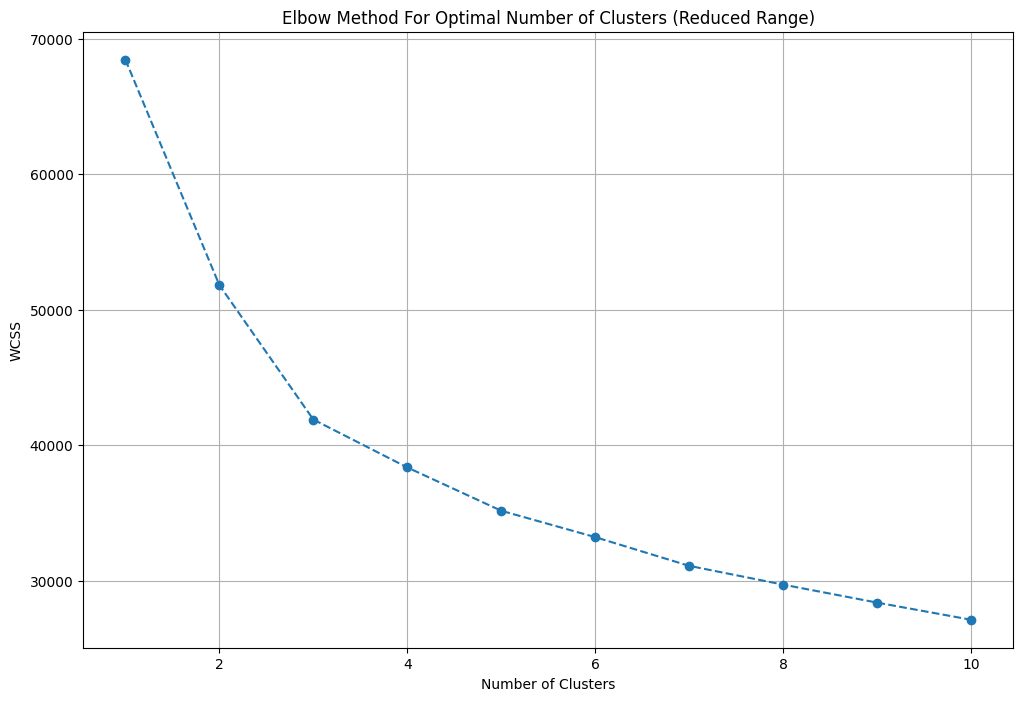

In [70]:
# Plot the results
plt.figure(figsize=(12,8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [71]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Predict the cluster assignment for each row
cluster_assignments = kmeans.predict(scaled_data)

/Users/saurabhsisodiya/Downloads/RealEstateMLProject/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [72]:
df = df.iloc[:,:-18]

In [73]:
df['furnishing_type'] = cluster_assignments

In [74]:
df.sample(5)[['furnishDetails','furnishing_type']]


,furnishDetails,furnishing_type
2813,"['3 Wardrobe', '6 Fan', '1 Exhaust Fan', '3 Geyser', '8 Light', '1 Modular Kitchen', '1 Chimney', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",2
2102,"['1 Water Purifier', '9 Fan', '1 Fridge', '1 Exhaust Fan', '1 Dining Table', '5 Geyser', '1 Stove', '21 Light', '8 AC', '1 Chimney', '5 Curtains', '1 Modular Kitchen', '4 TV', '7 Wardrobe', '1 Sofa', '1 Microwave', '1 Washing Machine', 'No Bed']",0
2168,NaN,1
1320,[],1
1902,"['3 Wardrobe', '1 Water Purifier', '1 Fan', '1 Exhaust Fan', '4 Geyser', '1 Light', '1 AC', '1 Modular Kitchen', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine']",2


## 5.Feature

In [75]:
df[['society','features']].sample(5)

,society,features
2273,central park resorts,"['Intercom Facility', 'Lift(s)', 'Swimming Pool', 'Park', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center', 'Rain Water Harvesting']"
2950,vipul tatvam villa,"['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Maintenance Staff', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Recently Renovated', 'Bank Attached Property', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Spacious Interiors', 'Low Density Society', 'Fitness Centre / GYM', 'Rain Water Harvesting', 'Club house / Community Center']"
780,dlf royalton tower,['Visitor Parking']
1159,smart world gems,NaN
623,shree vardhman victoria,"['Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Swimming Pool', 'Park', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center', 'Waste Disposal', 'Water softening plant']"


In [76]:
df['features'].isnull().sum()

635

In [81]:
app_df = pd.read_csv("apartments.csv")
app_df.head(2)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Smartworld One DXP,"2, 3, 4 BHK Apartment in Sector 113, Gurgaon","['Bajghera Road', 'Palam Vihar Halt', 'DPSG Palam Vihar', 'Park Hospital', 'Gurgaon Railway Station']","{'Bajghera Road': '800 Meter', 'Palam Vihar Halt': '2.5 KM', 'DPSG Palam Vihar': '3.1 KM', 'Park Hospital': '3.1 KM', 'Gurgaon Railway Station': '4.9 KM', 'The NorthCap University': '5.4 KM', 'Dwarka Expy': '1.2 KM', 'Hyatt Place Gurgaon Udyog Vihar': '7.7 KM', 'Dwarka Sector 21, Metro Station': '7.2 KM', 'Pacific D21 Mall': '7.4 KM', 'Indira Gandhi International Airport': '14.7 KM', 'Hamoni Golf Camp': '6.2 KM', 'Fun N Food Waterpark': '8.8 KM', 'Accenture DDC5': '9 KM'}",https://www.99acres.com/smartworld-one-dxp-sector-113-gurgaon-npxid-r400415,"{'2 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,370 sq.ft.', 'price-range': '₹ 2 - 2.4 Cr'}, '3 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,850 - 2,050 sq.ft.', 'price-range': '₹ 2.25 - 3.59 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '2,600 sq.ft.', 'price-range': '₹ 3.24 - 4.56 Cr'}}","['Swimming Pool', 'Salon', 'Restaurant', 'Spa', 'Cafeteria', 'Sun Deck', '24x7 Security', 'Club House', 'Gated Community']"
1,M3M Crown,"3, 4 BHK Apartment in Sector 111, Gurgaon","['DPSG Palam Vihar Gurugram', 'The NorthCap University', 'Park Hospital, Palam Vihar', 'Pacific D21 Mall', 'Palam Vihar Halt Railway Station']","{'DPSG Palam Vihar Gurugram': '1.4 Km', 'The NorthCap University': '4.4 Km', 'Park Hospital, Palam Vihar': '1.4 Km', 'Pacific D21 Mall': '8.2 Km', 'Palam Vihar Halt Railway Station': '1.2 Km', 'Dwarka Sector 21 Metro Station': '8.1 Km', 'Dwarka Expressway': '450 m', 'Fun N Food Water Park': '8.1 Km', 'Indira Gandhi International Airport': '14.1 Km', 'Tau DeviLal Sports Complex': '11.2 Km', 'Hamoni Golf Camp': '5 Km', 'Hyatt Place': '6.1 Km', 'Altrade Business Centre': '11.2 Km'}",https://www.99acres.com/m3m-crown-sector-111-gurgaon-npxid-r404068,"{'3 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '1,605 - 2,170 sq.ft.', 'price-range': '₹ 2.2 - 3.03 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '2,248 - 2,670 sq.ft.', 'price-range': '₹ 3.08 - 3.73 Cr'}}","['Bowling Alley', 'Mini Theatre', 'Manicured Garden', 'Swimming Pool', 'Flower Garden', 'Reading Lounge', 'Golf Course', 'Barbecue', 'Sauna']"


In [82]:
app_df['PropertyName'] = app_df['PropertyName'].str.lower()

In [84]:
temp_df = df[df['features'].isnull()]

In [85]:
temp_df.shape

(635, 26)

In [86]:
x = temp_df.merge(app_df, left_on='society', right_on='PropertyName', how='left')['TopFacilities']

In [87]:
df.loc[temp_df.index, 'features'] = x.values

In [88]:
df['features'].isnull().sum()

481

In [89]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

In [90]:
# Convert the string representation of lists in the 'features' columns to actual lists
df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [92]:
features_binary_df.sample(5)

,24/7 Power Backup,24/7 Water Supply,24x7 Security,ATM,Aerobics Centre,Air Hockey,Airy Rooms,Amphitheatre,Automated Car Wash,Badminton Court,Bank Attached Property,Banquet Hall,Bar/Chill-Out Lounge,Barbecue,Basketball Court,Beach Volley Ball Court,Billiards,Bowling Alley,Bus Shelter,Business Lounge,CCTV Camera Security,Cafeteria,Car Parking,Car wash area,Card Room,Centrally Air Conditioned,Changing Area,Children's Play Area,Cigar Lounge,Clinic,Club House,Club house / Community Center,Community Hall,Concierge Service,Conference room,Creche/Day care,Cricket Pitch,Doctor on Call,Earthquake Resistant,Entrance Lobby,False Ceiling Lighting,Feng Shui / Vaastu Compliant,Fire Fighting Systems,Fitness Centre / GYM,Flower Garden,Food Court,Foosball,Football,Fountain,Gated Community,Gazebo,Golf Course,Grocery Shop,Gymnasium,High Ceiling Height,High Speed Elevators,Infinity Pool,Intercom Facility,Internal Street Lights,Internet/wi-fi connectivity,Jacuzzi,Jogging Track,Landscape Garden,Laundry,Lawn Tennis Court,Library,Lift(s),Lounge,Low Density Society,Maintenance Staff,Manicured Garden,Medical Centre,Milk Booth,Mini Theatre,Multipurpose Court,Multipurpose Hall,Natural Light,Natural Pond,No open drainage around,Park,Party Lawn,Pergola,Piped Gas,Piped-gas,Pool Table,Power Back up Lift,Power Back-up,Private Garden / Terrace,Property Staff,RO System,Rain Water Harvesting,Reading Lounge,Recently Renovated,Reflexology Park,Restaurant,Salon,Sauna,School,Security / Fire Alarm,Security Personnel,Separate entry for servant room,Sewage Treatment Plant,Shopping Centre,Skating Rink,Solar Lighting,Solar Water Heating,Spa,Spacious Interiors,Squash Court,Steam Room,Sun Deck,Swimming Pool,Temple,Terrace Garden,Theatre,Toddler Pool,Valet Parking,Vastu Compliant,Video Door Security,Visitor Parking,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Softener Plant,Water Storage,Water purifier,Water softening plant,Wi-Fi Connectivity,Yoga/Meditation Area
1956,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
434,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3308,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2856,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [93]:
features_binary_df.shape

(3803, 130)

In [94]:
wcss_reduced = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_binary_df)
    wcss_reduced.append(kmeans.inertia_)

/Users/saurabhsisodiya/Downloads/RealEstateMLProject/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/saurabhsisodiya/Downloads/RealEstateMLProject/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/saurabhsisodiya/Downloads/RealEstateMLProject/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/saurabhsisodiya/Downloads/RealEstateMLP

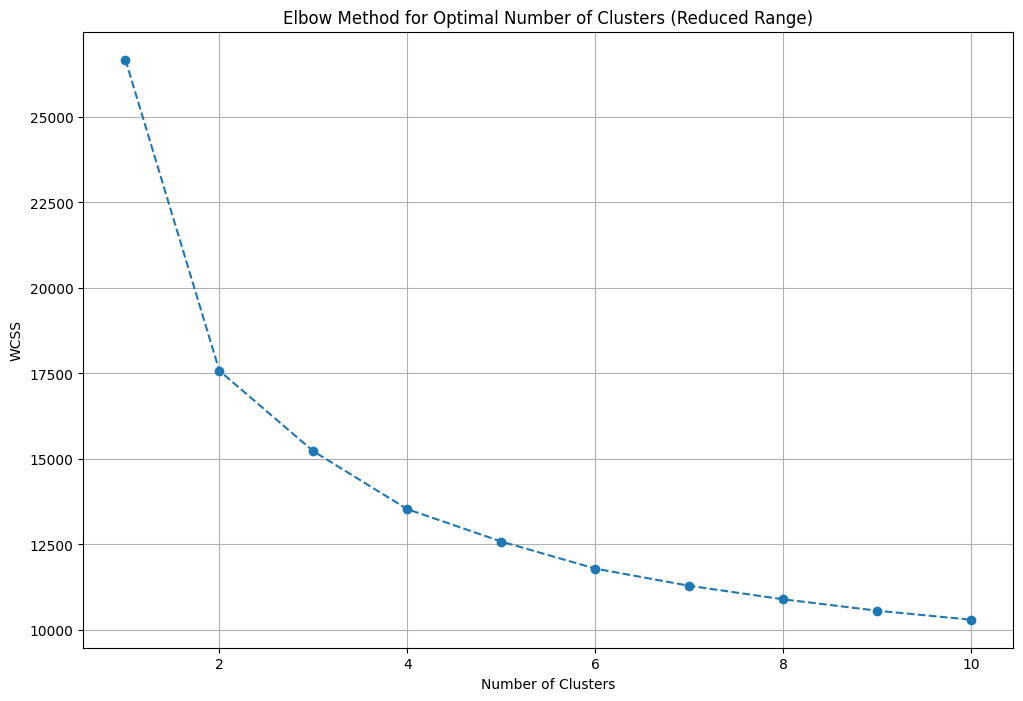

In [95]:
# Plot the results
plt.figure(figsize=(12,8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [101]:
# Define the weights for each feature as provided
# Assigning weights based on perceived luxury contribution
weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    'Bowling Alley': 8,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}

# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)


In [102]:
df['luxury_score'] = luxury_score

In [103]:
df.head()

,society,price,sector,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_type,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,features_list,luxury_score
0,ambience creacions,6.00,sector 22,20533.0,29221.0,Carpet area: 3000 (278.71 sq.m.),4,5,3+,"pooja room,servant room",10.0,South-East,New Property,"['Moulsari Avenue', 'Ambience Mall', 'Old Delhi Gurgaon Road', 'Gurgaon - Delhi Expy', 'Rotary Public School', 'The NorthCap University', 'Manipal Hospital, Palam Vihar', 'Indira Gandhi International Airport', 'Gurgaon Railway Station', 'Candor Techspace', 'Hyatt Place Gurgaon Udyog Vihar', 'Fun N Food WaterPark', 'Hamoni Golf Camp', 'Tau DeviLal Sports Complex']","['4 Wardrobe', '6 Fan', '1 Exhaust Fan', '4 Geyser', '1 Washing Machine', '6 Light', '1 Chimney', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']",NaN,NaN,NaN,3000.0,0,1,0,1,0,2,"[Feng Shui / Vaastu Compliant, Security / Fire Alarm, Intercom Facility, Lift(s), Maintenance Staff, Water Storage, Park, Visitor Parking]",49
1,m3m woodshire,1.00,sector 107,7496.0,13340.0,Super Built up area 1534(142.51 sq.m.)Carpet area: 1056 sq.ft. (98.11 sq.m.),2,2,3,study room,0.0,North-East,Relatively New,"['Signum 107', 'Nora Solomon Medicenter', 'Indira Gandhi International Airport', 'The Shikshiyan School', 'Najafgarh Jheel Bird Sanctuary', 'Skylark Cricket Academy']","['5 Fan', '1 Geyser', '5 Light', '4 AC', '1 Modular Kitchen', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Park', 'Natural Light']",NaN,1534.0,NaN,1056.0,1,0,0,0,0,1,"[Intercom Facility, Lift(s), Maintenance Staff, Park, Natural Light]",29
2,satya the legend,9.25,sector 57,16577.0,5580.0,Plot area 642(536.79 sq.m.)Built Up area: 630 sq.yards (526.76 sq.m.)Carpet area: 620 sq.yards (518.4 sq.m.),5,5,3+,"study room,servant room,pooja room,store room",4.0,North-East,Relatively New,"['HDFC Bank ATM', 'ICICI Bank ATM', 'YES Bank ATM', 'Axis Bank ATM', 'Indusind bank ATM', 'CK Birla Hospital', 'Suryadeep Hospital', 'Park Hospital', 'W Pratiksha Hospital', 'Cloudnine Hospital', 'Garari', 'Dreamz Cafe', 'Culinary Blend', 'Delectable Cafe', 'Dana Choga']","['1 Water Purifier', '9 Fan', '1 Exhaust Fan', '6 Geyser', '44 Light', '7 AC', '1 Modular Kitchen', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Fitness Centre / GYM', 'Club house / Community Center']",house,NaN,630.0,620.0,1,1,1,1,0,2,"[Centrally Air Conditioned, Water purifier, Security / Fire Alarm, Feng Shui / Vaastu Compliant, Private Garden / Terrace, High Ceiling Height, Maintenance Staff, False Ceiling Lighting, Water Storage, Separate entry for servant room, No open drainage around, Piped-gas, Internet/wi-fi connectivity, Recently Renovated, Visitor Parking, Swimming Pool, Park, Security Personnel, Natural L

In [104]:
df.drop(columns=['nearbyLocations', 'furnishDetails','features','features_list','additionalRoom'], inplace=True)

In [105]:
df.sample(5)

,society,price,sector,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,property_type,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
2793,sare green parc phase 3,1.0,sector 92,6875.0,14545.0,Carpet area: 1600 (148.64 sq.m.),4,3,2,12.0,North,New Property,NaN,NaN,NaN,1600.0,0,0,0,0,0,1,15
1274,shree vardhman victoria,1.0,sector 70,8518.0,11740.0,Super Built up area 1350(125.42 sq.m.),2,2,3,8.0,South-East,Relatively New,NaN,1350.0,NaN,NaN,1,0,0,0,1,1,49
2546,independent,0.5,sector 9,6083.0,822.0,Built Up area: 822 (76.37 sq.m.)Carpet area: 750 sq.ft. (69.68 sq.m.),3,2,1,1.0,NaN,Undefined,house,NaN,822.0,750.0,0,0,0,0,0,1,0
1967,ireo skyon,2.0,sector 60,16129.0,12400.0,Super Built up area 1550(144 sq.m.),2,3,2,4.0,North-West,Relatively New,NaN,1550.0,NaN,NaN,1,0,0,0,0,1,100
1277,dlf royalton tower,6.0,sector 43,20687.0,29004.0,Super Built up area 2997(278.43 sq.m.),4,4,3+,9.0,NaN,Moderately Old,NaN,2997.0,NaN,NaN,0,1,0,0,0,1,7


In [106]:
df.shape

(3803, 23)

In [107]:
df.to_csv('gurgaon_properties_cleaned_v2.csv', index=False)